In [1]:
import matplotlib.pyplot as plt
## 加载包
import pandas as pd

In [3]:
import statsmodels.api as sm
import pyflux as pf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv("data_newdate.csv")
datadf = data[['Bitcoin', 'Gold']]
datadf = np.log(datadf).diff().dropna()

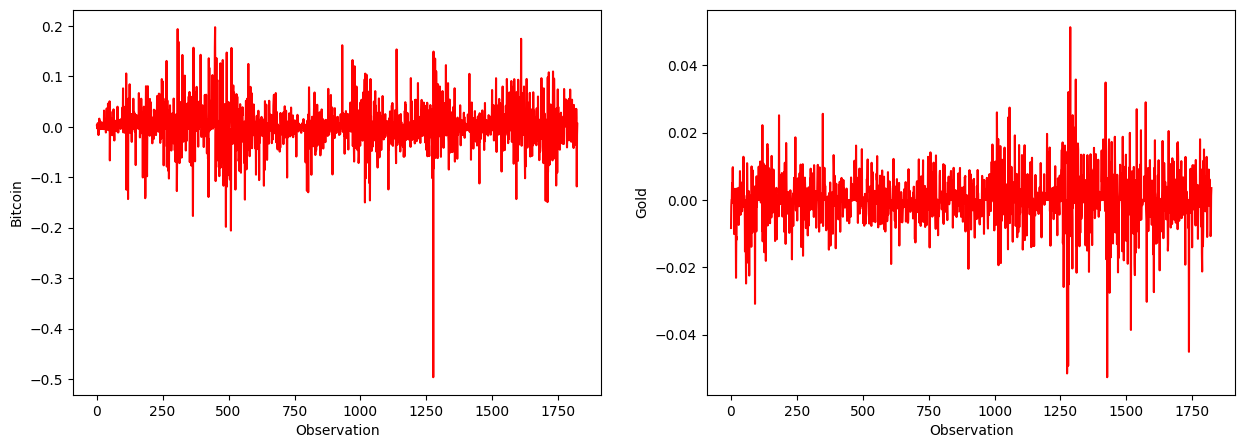

In [4]:
## 可视化两列数据
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
datadf.Bitcoin.plot(c="r")
plt.xlabel("Observation")
plt.ylabel("Bitcoin")
plt.subplot(1, 2, 2)
datadf.Gold.plot(c="r")
plt.xlabel("Observation")
plt.ylabel("Gold")
plt.show()

In [5]:
## 前面百分之80做训练集，后面百分之20做测试集
trainnum = np.int(datadf.shape[0] * 0.7)
traidata = datadf.iloc[0:trainnum, :]
testdata = datadf.iloc[trainnum:datadf.shape[0], :]

In [6]:
## 1:单位根检验检验序列的平稳性,ADF 检验
dftest = sm.tsa.adfuller(datadf.Bitcoin, autolag='BIC')
print(dftest)
print('\n')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
print("Bitcoin 检验结果：")
print(dfoutput)
print('\n')
dftest = sm.tsa.adfuller(datadf.Gold, autolag='BIC')
print(dftest)
print('\n')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
print("Gold 检验结果：")
print(dfoutput)

(-44.269410329497504, 0.0, 0, 1821, {'1%': -3.4339461240890983, '5%': -2.8631284882870625, '10%': -2.5676156576381293}, -6260.584604087936)


Bitcoin 检验结果：
Test Statistic                  -44.26941
p-value                           0.00000
Lags Used                         0.00000
Number of Observations Used    1821.00000
dtype: float64


(-43.40175099205733, 0.0, 0, 1821, {'1%': -3.4339461240890983, '5%': -2.8631284882870625, '10%': -2.5676156576381293}, -12599.301495508667)


Gold 检验结果：
Test Statistic                  -43.401751
p-value                           0.000000
Lags Used                         0.000000
Number of Observations Used    1821.000000
dtype: float64


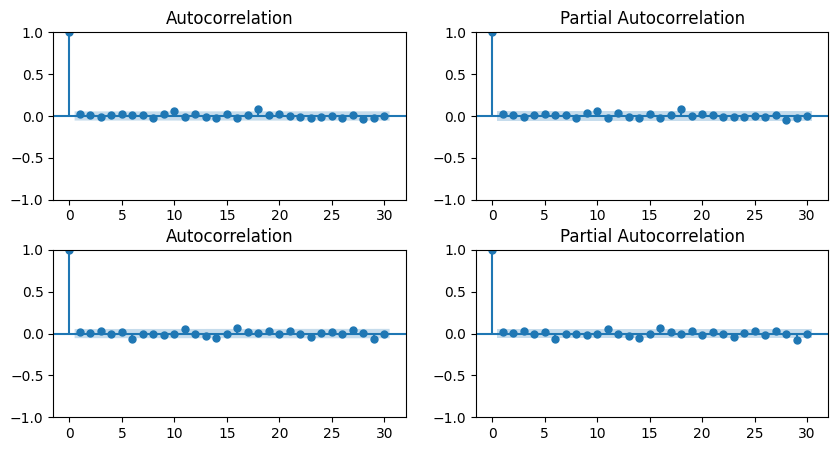

In [7]:
## 可视化序列的自相关和偏相关图
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(221)
plt.title("Bitcoin")
fig = sm.graphics.tsa.plot_acf(traidata.Bitcoin, lags=30, ax=ax1)
ax2 = fig.add_subplot(222)
plt.title("Bitcoin")
fig = sm.graphics.tsa.plot_pacf(traidata.Bitcoin, lags=30, ax=ax2)
ax3 = fig.add_subplot(223)
plt.title("Gold")
fig = sm.graphics.tsa.plot_acf(traidata.Gold, lags=30, ax=ax3)
ax4 = fig.add_subplot(224)
plt.title("Gold")
fig = sm.graphics.tsa.plot_pacf(traidata.Gold, lags=30, ax=ax4)
plt.subplots_adjust(hspace=0.3)
plt.show()

Normal ARIMAX(3,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Bitcoin                             Method: MLE                                       
Start Date: 4                                           Log Likelihood: 2276.1008                         
End Date: 1275                                          AIC: -4536.2017                                   
Number of observations: 1272                            BIC: -4495.0149                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.2631     0.2049     1.2843   0.199    (-0.1384 | 0.6646)       
AR(2)                                

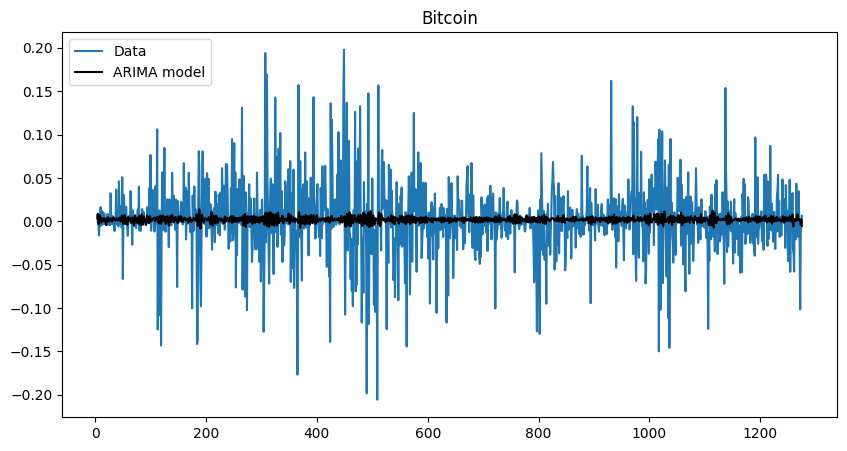

In [8]:
## 建立ARIMAX（3，0，2）模型
model = pf.ARIMAX(data=traidata, formula="Bitcoin~Gold", ar=3, ma=2, integ=0)
model_1 = model.fit("MLE")
print(model_1.summary())
# 可视化模型在训练集上的拟合情况
model.plot_fit(figsize=(10, 5))
plt.show()

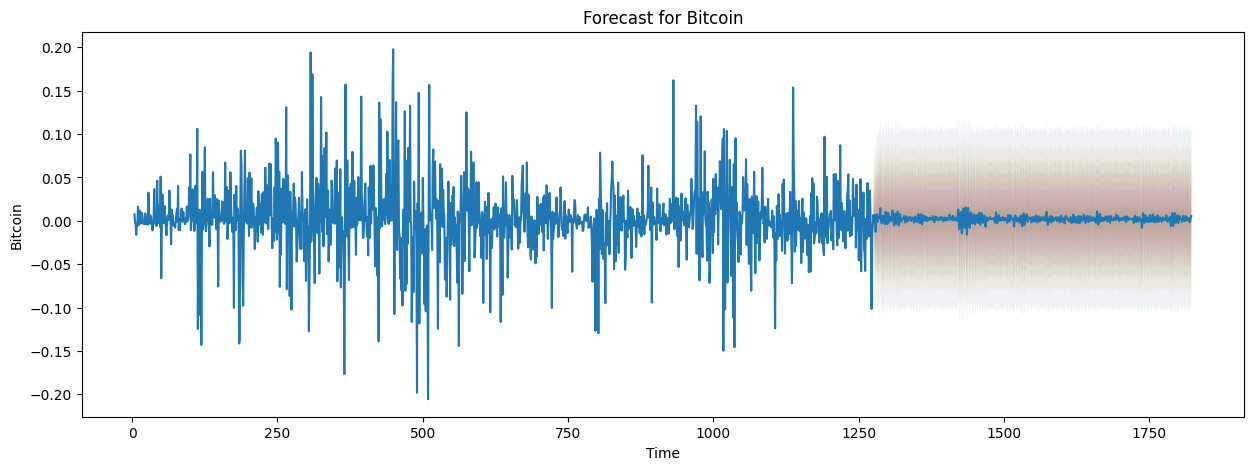

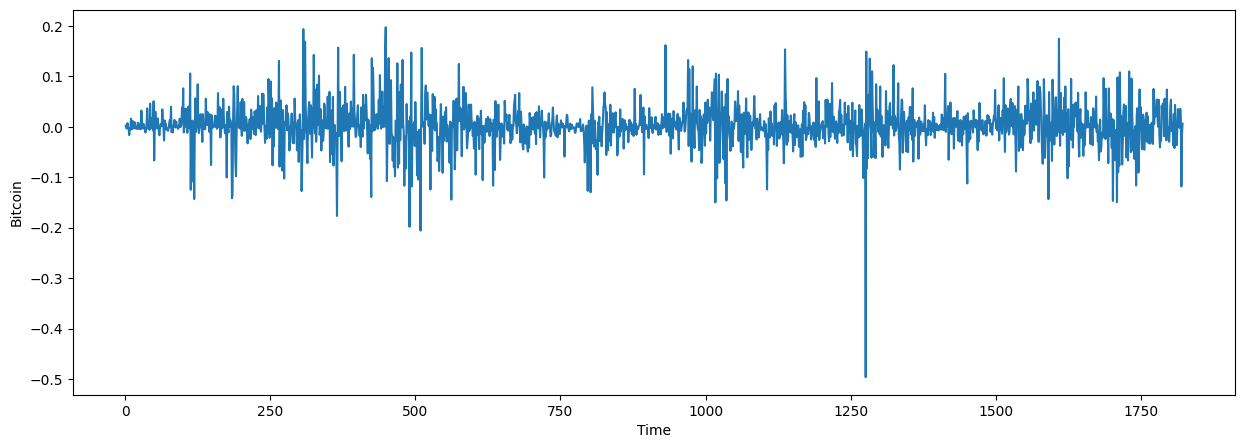

In [9]:
## 可视化模型的在测试集上的预测结果
model.plot_predict(h=testdata.shape[0],  ## 往后预测多少步
                   oos_data=testdata,  ## 测试数据集
                   past_values=traidata.shape[0],  ## 图像显示训练集的多少数据
                   figsize=(15, 5))
## 可视化原始数据
datadf.Bitcoin.plot(figsize=(15, 5))
plt.xlabel("Time")
plt.ylabel("Bitcoin")
plt.show()

在测试集上mean absolute error: 0.02903304346325613
在测试集上mean squared error: 0.0020155578671662375
在测试集上r2: 0.005892633095700983


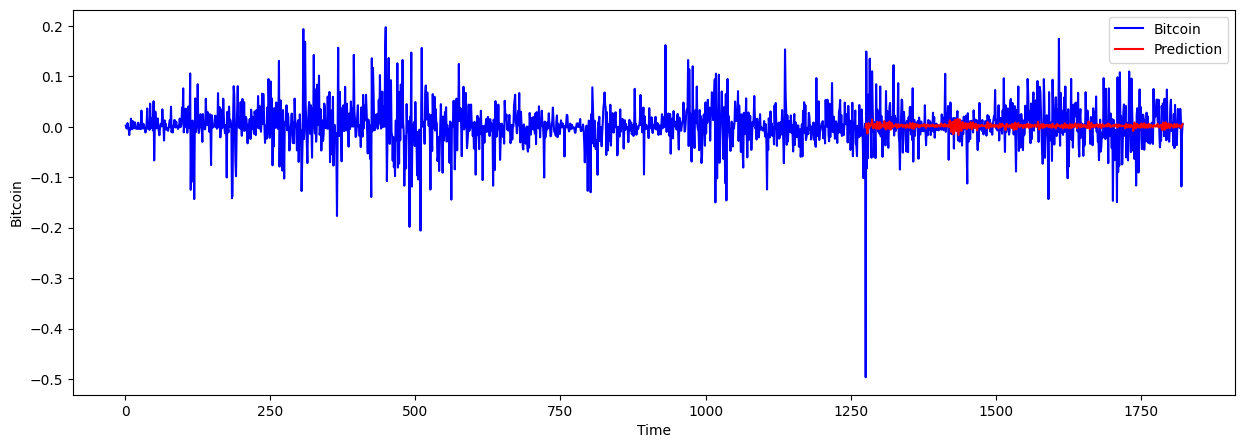

In [15]:
## 预测新的数据
C02pre = model.predict(h=testdata.shape[0],  ## 往后预测多少步
                       oos_data=testdata,  ## 测试数据集
                       )
print("在测试集上mean absolute error:", mean_absolute_error(testdata.Bitcoin, C02pre.Bitcoin))
print("在测试集上mean squared error:", mean_squared_error(testdata.Bitcoin, C02pre.Bitcoin))
print("在测试集上r2:", r2_score(testdata.Bitcoin, C02pre.Bitcoin))
## 可视化原始数据和预测数据进行对比
datadf.Bitcoin.plot(figsize=(15, 5), c="b", label="Bitcoin")
C02pre.Bitcoin.plot(c="r", label="Prediction")
plt.xlabel("Time")
plt.ylabel("Bitcoin")
plt.legend(loc=0)
plt.show()

In [16]:
p = np.arange(6)
q = np.arange(6)
pp, qq = np.meshgrid(p, q)
resultdf = pd.DataFrame(data={"arp": pp.flatten(), "mrq": qq.flatten()})
resultdf["bic"] = np.double(pp.flatten())
resultdf["mae"] = np.double(qq.flatten())
## 迭代循环建立多个模型
for ii in resultdf.index:
    model_i = pf.ARIMAX(data=traidata, formula="Bitcoin~Gold", ar=resultdf.arp[ii], ma=resultdf.mrq[ii], integ=0)
    try:
        modeli_fit = model_i.fit("MLE")
        bic = modeli_fit.bic
        print(ii, bic)
        C02_pre = model_i.predict(h=testdata.shape[0], oos_data=testdata)
        mae = mean_absolute_error(testdata.Bitcoin, C02_pre.Bitcoin)
    except:
        bic = np.nan
    resultdf.bic[ii] = bic
    resultdf.mae[ii] = mae
print("模型迭代结束")
print(resultdf.sort_values(by="bic").head())

0 -4541.842575999092
1 -4530.797513334867
2 -4519.290885831338
3 -4507.968243404791
4 -4496.531354794154
5 -4485.945528644665
6 -4530.752126092162
7 -4523.751503878547
8 -4512.132002297089
9 -4500.824308302659
10 -4489.641317775284
11 -4478.962081208959
12 -4519.328214321619
13 -4512.182162276304
14 -4505.550143581419
15 -4495.014885085953
16 -4482.744509166137
17 -4471.925101977709
18 -4508.102576929642
19 -4500.958113285905
20 -4494.341960185227
21 -4487.266108766512
22 -4475.695365535577
23 -4464.7881196170065
24 -4496.647637734564
25 -4489.7798769319415
26 -4482.76070134466
27 -4475.757625792334
28 -4516.412959740622
29 -4469.839024768391
30 -4485.762345631376
31 -4478.883925025835
32 -4471.760573312637
33 -4464.578828085336
34 -4469.924681951192
35 -4495.33413828838
模型迭代结束
    arp  mrq          bic       mae
0     0    0 -4541.842576  0.029132
1     1    0 -4530.797513  0.029124
6     0    1 -4530.752126  0.029132
7     1    1 -4523.751504  0.029084
12    0    2 -4519.328214  0.02

GARCH


e:\anaconda\lib\site-packages\arch\univariate\base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


ARCH


e:\anaconda\lib\site-packages\arch\univariate\base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


EGARCH


e:\anaconda\lib\site-packages\arch\univariate\base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


FIARCH


e:\anaconda\lib\site-packages\arch\univariate\base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


HARCH


e:\anaconda\lib\site-packages\arch\univariate\base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


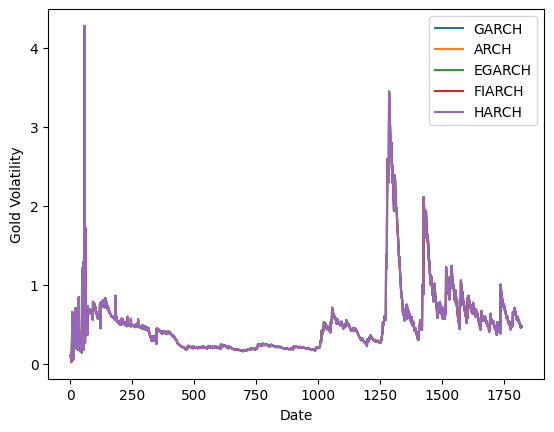

In [17]:
data = pd.read_csv("data-newDate.csv")
gold_data = data[['Date', 'Gold']]
gold_market = gold_data["Gold"]
gold_returns = 100 * gold_market.pct_change().dropna()
bitcoin_returns = 100 * data[['Bitcoin']].pct_change().dropna()

from arch import arch_model
from arch.__future__ import reindexing

reindexing = True

for mode in ['GARCH', 'ARCH', 'EGARCH', 'FIARCH', 'HARCH']:
    print(mode)
    gold_volatility = []
    bitcoin_volatility = []
    for i in range(1, gold_returns.shape[0] + 1):
        am1 = arch_model(gold_returns[:i], vol=mode)  # vol参数改成对应的mode
        res1 = am1.fit(update_freq=0, disp='off')
        #am2 = arch_model(bitcoin_returns[:i],vol='GARCH')
        #res2 = am2.fit(update_freq=0, disp='off')
        gold_volatility.append(res1.forecast().residual_variance.iloc[-1]['h.1'])
        #bitcoin_volatility.append(res2.forecast().residual_variance.iloc[-1]['h.1'])
    plt.plot(gold_volatility)

plt.legend(['GARCH', 'ARCH', 'EGARCH', 'FIARCH', 'HARCH'])
plt.xlabel("Date")
plt.ylabel("Gold Volatility")
plt.show()
#plt.plot(bitcoin_volatility)
#plt.show()